### Human activity recognition.
The dataset: <http://archive.ics.uci.edu/ml/datasets/Activity+Recognition+from+Single+Chest-Mounted+Accelerometer#>

In [7]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import mode

In [9]:
def read_data(fname='all'):
    print('::::Read Data::::')
    freq = '19230U'   # ~19ms, using sampling frequency is 52samples/sec
    dt = datetime.now()
    data = pd.DataFrame()
    
    if fname == 'all':    # read all files
        data_files = []
        
        for f_id in range(1,16):
            data = pd.read_csv('data/%d.csv' %f_id, 
                               names=['id', 'arrival_time', 'creation_time', 'x', 'y', 'z', 'user', 'model', 'device', 'label'], 
                               header=None, index_col=0,usecols=['id','x','y','z','label'])
            data.index = pd.date_range(start=dt, periods=data.shape[0], freq=freq)
            dt += timedelta(hours=3)
            data_files.append(data)
            
        data = pd.concat(data_files)
    
    else:    # read one file only
        data = pd.read_csv('data/%s.csv' %fname, 
                   names=['id', 'arrival_time', 'creation_time', 'x', 'y', 'z', 'user', 'model', 'device', 'label'], 
                   header=None, index_col=0, usecols=['id','x','y','z','label'])

        data.index = pd.date_range(start='00:00:00', periods=data.shape[0], freq=freq)
        
    # Filter and clean data
    data = data.dropna()
    data = data[data['label'] != 0]   # some rows are misclassified as 0
        
    return data

### Feature extraction.
Segment the data using sliding window of size 10s, and from each window extract the common features (mean, standard deviation, variance), and some other features used specifically for Human Activity Recognition like RMS (Root Mean Square), magnitude of acceleration, and pairwise correlation between x, y, z.

In [10]:
def rms(ts): return np.sqrt(np.mean(ts**2))

def corr(df): 
    cor = df.corr()
    return pd.DataFrame({'xy':[cor['x']['y']], 'xz':[cor['x']['z']], 'yz':[cor['y']['z']]})

def get_simple_features(data, wsize='10s', f_list=['mean', 'std', 'var', rms]):
    print('::::START:::: Get Simple Features::::')
    # f_list is a list of features names or methods to apply in resampling
    
    # features that invlove one dimension only.
    fname = '_' + (f_list[0] if isinstance(f_list[0], str) else f_list[0].__name__)   
    feats = data[['x','y','z']].resample(wsize, how=f_list[0]).add_suffix(fname)
    
    for i, f in enumerate(f_list[1:]):
        fname = '_' + (f if isinstance(f, str) else f.__name__)
        feat = data[['x','y','z']].resample(wsize, how=f).add_suffix(fname)
        feats = feats.join(feat)   

    # features that involve more than one dimension.                                               
    mean_mag = (data**2).sum(axis=1).resample(wsize, how=lambda ts: np.sqrt(ts).mean())
    mean_mag.name = 'mean_mag'
    feats = feats.join(mean_mag) 

    pairs_cor = data.groupby(pd.TimeGrouper(wsize)).apply(corr).reset_index(1, drop=True)
    feats = feats.join(pairs_cor) 
    
    y = data['label'].resample(wsize, how=lambda ts: mode(ts)[0] if ts.shape[0] > 0 else np.nan)   

    # drop any nan values
    mask = np.any(np.isnan(feats), axis=1)
    feats, y = feats[~mask], y[~mask]
    mask = np.isnan(y)
    feats, y = feats[~mask], y[~mask]
    print('::::END:::: Get Simple Features::::')
    return (feats, y)


### Choosing and tuning the model.

Splitting data (after feature extraction) into train and test subsets. Using grid search on the training set each model is trained and tuned, then the models are compared according to their performance on the test set using accuracy and AUC (Area Under ROC Curve). The best accuracy result of .899 for SVM and RandomForest, and best AUC result of .99 for RandomForest.

    Activity codes in confusion matrix:
    1: Working at Computer
    2: Standing Up, Walking and Going up\down stairs
    3: Standing
    4: Walking
    5: Going Up\Down Stairs
    6: Walking and Talking with Someone
    7: Talking while Standing
    

In [11]:
def train_model(X, y, est, grid):
    print('::::Train Model::::')
    gs = GridSearchCV(estimator=est, param_grid=grid, scoring='accuracy', cv=5, n_jobs=-1)
    gs = gs.fit(X, y)
    
    return (gs.best_estimator_, gs.best_params_)

def eval_model(mod, X_test, y_test, mod_name, plt_roc=True):
    print('::::Eval Model::::')
    y_prob = mod.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5, 6])
    
    y_test_bin_ravel = y_test_bin.ravel()
    y_prob_ravel = y_prob.ravel()
    
    y_test_bin_ravel = y_test_bin_ravel[:len(y_prob_ravel)]
    
    fpr, tpr, _ = roc_curve(y_test_bin_ravel, y_prob_ravel)
    roc_auc = auc(fpr, tpr)
    
    if plt_roc:
        plt.plot(fpr, tpr, lw=2,
                 label='average ROC curve (auc=%0.2f), model: %s' % (roc_auc,mod_name))
        plt.legend(loc="lower right")
    
    y_pred = mod.predict(X_test)
    score = accuracy_score(y_true=y_test, y_pred=y_pred)
    print('Accuracy score on the test set: %.3f' %score)
    
    confusion_ma = confusion_matrix(y_true=y_test, y_pred=y_pred)
    confusion_ma = pd.DataFrame(confusion_ma, index=list(range(1,8)), columns=list(range(1,8)))
    print('Confusion Matrix...')
    print(confusion_ma)
    
    return (roc_auc, score)


<h2>Test Example</h2>

::::Read Data::::
::::START:::: Get Simple Features::::
::::END:::: Get Simple Features::::
Support Vector Machine
::::Train Model::::
::::Eval Model::::
Accuracy score on the test set: 0.966


ValueError: Shape of passed values is (6, 6), indices imply (7, 7)

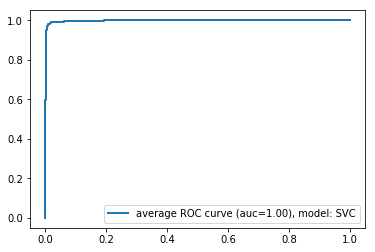

In [12]:
data = read_data('Phones_accelerometer')
param_range = [0.0001, 0.001, 0.01, 0.1]

feats, y = get_simple_features(data, wsize='10s')
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25, random_state=0, stratify=y)


print('Support Vector Machine')
model, params = train_model(X_train, y_train, 
                    est=SVC(probability=True),
                    grid={'C': param_range, 'gamma': param_range, 'kernel': ['linear']})
eval_model(model, X_test, y_test, 'SVC')
              
print('Random Forest')
model, params = train_model(X_train, y_train, 
                    est=RandomForestClassifier(n_jobs=-1, criterion='entropy'),
                    grid={'n_estimators':[50, 100, 200]})
eval_model(model, X_test, y_test,'Forest')

print('Gradient Boosting')
model, params = train_model(X_train, y_train, 
                    est=GradientBoostingClassifier(learning_rate=1.0, random_state=0),
                    grid={'n_estimators':[50, 200, 400], 'max_depth':[1,2,3],
                          'learning_rate':[.1,.05,.01,.005]})
eval_model(model, X_test, y_test,'GBC')

print('Ada Boosting')
model, params = train_model(X_train, y_train, 
                    est=AdaBoostClassifier(),
                    grid={'n_estimators':[50, 200, 400], 'learning_rate':[.1,.05,.01,.005]})
eval_model(model, X_test, y_test,'ABC')

print('K-Nearest Neighbor')
model, params = train_model(X_train, y_train, 
                    est=KNeighborsClassifier(),
                    grid={'n_neighbors':[5, 8, 10], 'weights':['uniform', 'distance']})
eval_model(model, X_test, y_test,'KNN')

### Trying different windows sizes.

The choice of a window size of 10sec was quite arbitrary. In the research papers on HAR different window sizes were used that range from 1 sec to 20 sec.
Also two types of windows are used in the field, disjoint and overlapping. get_features2 defines the same features defined before but using rolling window and taking only values at overlapping of 50%.
AUC scores are comparable, and the best accuracy score is .92 for overlapping-window of size 2sec.

In [ ]:
def get_advanced_features(data, wsize_sec, overlap=.5):
    print('::::START:::: Get Advance Features ::::')
    
    wsize = int(10*wsize_sec)
    feats = data[['x','y','z']].rolling(wsize,int(wsize/2)).mean().add_suffix('_mean')
    feat = data[['x','y','z']].rolling(wsize, int(wsize/2)).std().add_suffix('_std')
    feats = feats.join(feat)
    
    feat = data[['x','y','z']].rolling(wsize, int(wsize/2)).var().add_suffix('_var')
    feats = feats.join(feat)
    
    feat = data[['x','y','z']].rolling(wsize, int(wsize/2)).apply(rms).add_suffix('_rms')
    feats = feats.join(feat)
        
    mean_mag = (data**2).sum(axis=1).rolling(wsize, int(wsize/2)).apply(lambda ts: np.sqrt(ts).mean())
    mean_mag.name = 'mean_mag'
    feats = feats.join(mean_mag) 
    
    pairs_cor_ = data[['x','y','z']].rolling(window=int(wsize/2)).corr(other=data[['x','y','z']])
    feats = feats.join(pairs_cor_)
    
    y = data[['label']].rolling(wsize, int(wsize/2)).apply(lambda ts: mode(ts)[0])  
    feats = feats.iloc[int(wsize*overlap)::int(wsize*overlap)] 
    
    y = y.iloc[int(wsize*overlap)::int(wsize*overlap)]
    print('::::END:::: Get features Advance::::')
    return feats, y

    

<h2>Test Example</h2>

In [ ]:
win_sizes = ['2']#,'3', '5', '7', '10', '13', '15', '20']
best_model = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=50)

for wsize in win_sizes:
    print('Window Size: %s sec' % wsize)
    print('Min periodos:', int(wsize)/2)
    try:
        # disjoint window
        print('Disjoint window:')
        feats, y = get_simple_features(data, wsize=wsize + 's')
        X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                            random_state=0, stratify=y)
        best_model.fit(X_train, y_train)
        roc_auc, acc = eval_model(best_model, X_test, y_test,'%ss - disjoint' %wsize, plt_roc=False)
        print('AUC score: %.3f' % roc_auc)


        # overlapping window
        print('Overlapping window:')
        feats, y = get_advanced_features(data, int(wsize))
        X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                            random_state=0, stratify=y)
        best_model.fit(X_train, y_train)
        roc_auc, acc = eval_model(best_model, X_test, y_test,'%ss - overlapping' %wsize, plt_roc=False)
        print('AUC score: %.3f' % roc_auc)
    except Exception as e:
        print(e)

### Testing model on the full dataset.

In [ ]:
data2 = read_data('all') 
feats, y = get_advanced_features(data2, 2)
X_train, X_test, y_train, y_test = train_test_split(feats, y, test_size=.25,
                                                    random_state=0, stratify=y)
best_model.fit(X_train, y_train)
eval_model(best_model, X_test, y_test,'2sec - overlapping')
